# Species richness layer creation

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import fiona
import requests
import re
import json

In [2]:

sp_api = pd.read_csv('../../../../data/UPDATED_Species_Locations.csv')
sp_api

,location_id,specie_id
0,2346.0,6
1,2346.0,22
2,2346.0,49
3,2346.0,54
4,2029.0,4
...,...,...
1196,3037.0,51
1197,4170.0,6
1198,4170.0,22
1199,2690.0,16


In [3]:
sp_richness_ids = sp_api.groupby('location_id').agg({'specie_id': lambda x: list(x)})
sp_richness_ids['sp_count'] = sp_richness_ids['specie_id'].apply(lambda x: len(x))
sp_richness_ids.reset_index(inplace=True)
sp_richness_ids.rename(columns={'specie_id':'species_id'}, inplace=True)
sp_richness_ids['location_id'] = sp_richness_ids['location_id'].apply(lambda x: int(x))
sp_richness_ids

,location_id,species_id,sp_count
0,1645,[16],1
1,1652,"[4, 16, 22, 30, 39, 44, 52, 57, 64]",9
2,1681,"[2, 3, 4, 6, 9, 10, 12, 16, 17, 20, 22, 24, 25...",33
3,1695,"[4, 5, 14, 19, 31, 42, 51]",7
4,1712,"[2, 3, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24,...",37
...,...,...,...
113,4543,"[4, 5, 14, 31, 42, 51, 53]",7
114,4559,[16],1
115,4587,"[3, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24, 25...",32
116,4616,"[2, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24, 25...",36


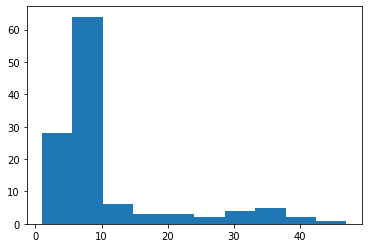

In [4]:
plt.hist(sp_richness_ids['sp_count'])
plt.show()

## Add to locations

In [5]:
locations_file = 'https://storage.googleapis.com/mangrove_atlas/boundaries/processed/location_final/locations_v3_not_merged_with_old.gpkg'
locations = gpd.read_file(locations_file)
locations = locations[locations['type'] == 'country']
locations.head()

,name,iso,type,area_m2,wdpaid,globalid,perimeter_m,location_idn,coast_length_m,geometry
82,Qatar,QAT,country,3.880224,NaN,{AF97ABE2-6405-4438-A7ED-1494A43DA379},8.392644,06d2e6f9-bc89-59bf-a0e2-ab804e5db9fd,1345769.96,"MULTIPOLYGON (((50.73769 24.93464, 50.73779 24..."
89,Mayotte,MYT,country,5.611808,NaN,{57E86B5B-7EF0-4754-A8D4-A9DC3212D421},10.086238,0750953f-4af9-549b-aeea-329663249a56,291036.71,"POLYGON ((46.63483 -12.96039, 46.63197 -12.969..."
118,Vietnam,VNM,country,90.156489,NaN,{B2A84FBB-34CD-4A51-9463-B9DB2DB62A10},81.714911,09a1ab14-11ad-56ec-8acb-a149e5697abd,9005760.08,"MULTIPOLYGON (((104.31952 10.36051, 104.31975 ..."
132,Grenada,GRD,country,2.154728,NaN,{F8753179-5FFA-4D9E-8AD9-083F31C48528},6.743601,0b0ecb56-bb8e-5ef1-b8ee-3cdad67fed0e,260664.47,"MULTIPOLYGON (((-61.91525 11.37330, -61.91813 ..."
149,India,IND,country,473.029671,NaN,{A4A6CE4D-8D03-4246-9A2F-BD9811232115},211.564078,0c07ca53-7b17-5650-a2c6-0cc27249a4bd,16917891.22,"MULTIPOLYGON (((79.52922 9.38411, 79.52921 9.3..."


In [6]:
api_locs = pd.read_csv('https://storage.googleapis.com/mangrove_atlas/widget_data/locations_staging.csv')
api_locs.rename(columns={'location_id': 'location_idn'}, inplace=True)
api_locs.head()

,id,location_idn
0,1563,000bd204-c0fd-510b-a1ad-132a7ef7470d
1,1564,00250a0f-f66d-54a0-b7a3-d80035881cbf
2,1565,0041637b-f6a2-5b89-87ce-850f5c5431b3
3,1566,005b49ef-6b7f-575a-85b3-ff19261a0755
4,1567,00921349-70fb-5a7e-8207-b3157aecc349


In [7]:
sp_richness_loc = pd.merge(sp_richness_ids, api_locs, left_on='location_id', right_on='id', how = 'left')
sp_richness_loc.drop(columns=['id', 'location_id'], inplace=True)
sp_richness_loc

,species_id,sp_count,location_idn
0,[16],1,06d2e6f9-bc89-59bf-a0e2-ab804e5db9fd
1,"[4, 16, 22, 30, 39, 44, 52, 57, 64]",9,0750953f-4af9-549b-aeea-329663249a56
2,"[2, 3, 4, 6, 9, 10, 12, 16, 17, 20, 22, 24, 25...",33,09a1ab14-11ad-56ec-8acb-a149e5697abd
3,"[4, 5, 14, 19, 31, 42, 51]",7,0b0ecb56-bb8e-5ef1-b8ee-3cdad67fed0e
4,"[2, 3, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24,...",37,0c07ca53-7b17-5650-a2c6-0cc27249a4bd
...,...,...,...
113,"[4, 5, 14, 31, 42, 51, 53]",7,f1a0d30d-f138-552d-b77f-800b015570cd
114,[16],1,f309afe5-27b5-575a-aa2c-7598a53dffa4
115,"[3, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24, 25...",32,f58d8175-a251-50e8-b1e1-756d60d70d96
116,"[2, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24, 25...",36,f848599b-9858-59d4-afe3-02c21321630e


In [8]:
species_locations_final = pd.merge(sp_richness_loc, locations, on='location_idn', how='right')
species_locations_final

,species_id,sp_count,location_idn,name,iso,type,area_m2,wdpaid,globalid,perimeter_m,coast_length_m,geometry
0,[16],1.0,06d2e6f9-bc89-59bf-a0e2-ab804e5db9fd,Qatar,QAT,country,3.880224,NaN,{AF97ABE2-6405-4438-A7ED-1494A43DA379},8.392644,1345769.96,"MULTIPOLYGON (((50.73769 24.93464, 50.73779 24..."
1,"[4, 16, 22, 30, 39, 44, 52, 57, 64]",9.0,0750953f-4af9-549b-aeea-329663249a56,Mayotte,MYT,country,5.611808,NaN,{57E86B5B-7EF0-4754-A8D4-A9DC3212D421},10.086238,291036.71,"POLYGON ((46.63483 -12.96039, 46.63197 -12.969..."
2,"[2, 3, 4, 6, 9, 10, 12, 16, 17, 20, 22, 24, 25...",33.0,09a1ab14-11ad-56ec-8acb-a149e5697abd,Vietnam,VNM,country,90.156489,NaN,{B2A84FBB-34CD-4A51-9463-B9DB2DB62A10},81.714911,9005760.08,"MULTIPOLYGON (((104.31952 10.36051, 104.31975 ..."
3,"[4, 5, 14, 19, 31, 42, 51]",7.0,0b0ecb56-bb8e-5ef1-b8ee-3cdad67fed0e,Grenada,GRD,country,2.154728,NaN,{F8753179-5FFA-4D9E-8AD9-083F31C48528},6.743601,260664.47,"MULTIPOLYGON (((-61.91525 11.37330, -61.91813 ..."
4,"[2, 3, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24,...",37.0,0c07ca53-7b17-5650-a2c6-0cc27249a4bd,India,IND,country,473.029671,NaN,{A4A6CE4D-8D03-4246-9A2F-BD9811232115},211.564078,16917891.22,"MULTIPOLYGON (((79.52922 9.38411, 79.52921 9.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...
117,[16],1.0,f309afe5-27b5-575a-aa2c-7598a53dffa4,Bahrain,BHR,country,0.747710,NaN,{162FB878-D279-46F0-AA36-1576B037F6CD},4.140048,835126.13,"MULTIPOLYGON (((50.73625 25.55955, 50.73696 25..."
118,"[3, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24, 25...",32.0,f58d8175-a251-50e8-b1e1-756d60d70d96,Bangladesh,BGD,country,21.939479,NaN,{7B3B4319-07D7-46CB-8C19-1874145B0F16},48.284828,6183971.14,"MULTIPOLYGON (((88.98312 22.37699, 88.98315 22..."
119,"[2, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24, 25...",36.0,f848599b-9858-59d4-afe3-02c21321630e,Myanmar,MMR,country,100.061760,NaN,{29256DE5-54CA-48E1-BB26-0C45D4A0C4B1},78.321714,18014085.81,"MULTIPOLYGON (((97.80042 8.82479, 97.80032 8.8..."
120,NaN,NaN,f91064fe-8030-5230-b71a-4b486d80b1e4,Sint Maarten,SXM,country,0.042989,NaN,{71F7C005-4959-4897-84F7-D43BC60B7935},0.893504,51214.48,"POLYGON ((-63.01409 18.05032, -63.01300 18.049..."


In [9]:
species_locations_final_gdf = gpd.GeoDataFrame(species_locations_final).copy()
species_locations_final_gdf['species_id'] = species_locations_final_gdf['species_id'].apply(lambda x: str(x))
print(species_locations_final_gdf.crs)
display(species_locations_final_gdf)


epsg:4326


,species_id,sp_count,location_idn,name,iso,type,area_m2,wdpaid,globalid,perimeter_m,coast_length_m,geometry
0,[16],1.0,06d2e6f9-bc89-59bf-a0e2-ab804e5db9fd,Qatar,QAT,country,3.880224,NaN,{AF97ABE2-6405-4438-A7ED-1494A43DA379},8.392644,1345769.96,"MULTIPOLYGON (((50.73769 24.93464, 50.73779 24..."
1,"[4, 16, 22, 30, 39, 44, 52, 57, 64]",9.0,0750953f-4af9-549b-aeea-329663249a56,Mayotte,MYT,country,5.611808,NaN,{57E86B5B-7EF0-4754-A8D4-A9DC3212D421},10.086238,291036.71,"POLYGON ((46.63483 -12.96039, 46.63197 -12.969..."
2,"[2, 3, 4, 6, 9, 10, 12, 16, 17, 20, 22, 24, 25...",33.0,09a1ab14-11ad-56ec-8acb-a149e5697abd,Vietnam,VNM,country,90.156489,NaN,{B2A84FBB-34CD-4A51-9463-B9DB2DB62A10},81.714911,9005760.08,"MULTIPOLYGON (((104.31952 10.36051, 104.31975 ..."
3,"[4, 5, 14, 19, 31, 42, 51]",7.0,0b0ecb56-bb8e-5ef1-b8ee-3cdad67fed0e,Grenada,GRD,country,2.154728,NaN,{F8753179-5FFA-4D9E-8AD9-083F31C48528},6.743601,260664.47,"MULTIPOLYGON (((-61.91525 11.37330, -61.91813 ..."
4,"[2, 3, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24,...",37.0,0c07ca53-7b17-5650-a2c6-0cc27249a4bd,India,IND,country,473.029671,NaN,{A4A6CE4D-8D03-4246-9A2F-BD9811232115},211.564078,16917891.22,"MULTIPOLYGON (((79.52922 9.38411, 79.52921 9.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...
117,[16],1.0,f309afe5-27b5-575a-aa2c-7598a53dffa4,Bahrain,BHR,country,0.747710,NaN,{162FB878-D279-46F0-AA36-1576B037F6CD},4.140048,835126.13,"MULTIPOLYGON (((50.73625 25.55955, 50.73696 25..."
118,"[3, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24, 25...",32.0,f58d8175-a251-50e8-b1e1-756d60d70d96,Bangladesh,BGD,country,21.939479,NaN,{7B3B4319-07D7-46CB-8C19-1874145B0F16},48.284828,6183971.14,"MULTIPOLYGON (((88.98312 22.37699, 88.98315 22..."
119,"[2, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24, 25...",36.0,f848599b-9858-59d4-afe3-02c21321630e,Myanmar,MMR,country,100.061760,NaN,{29256DE5-54CA-48E1-BB26-0C45D4A0C4B1},78.321714,18014085.81,"MULTIPOLYGON (((97.80042 8.82479, 97.80032 8.8..."
120,nan,NaN,f91064fe-8030-5230-b71a-4b486d80b1e4,Sint Maarten,SXM,country,0.042989,NaN,{71F7C005-4959-4897-84F7-D43BC60B7935},0.893504,51214.48,"POLYGON ((-63.01409 18.05032, -63.01300 18.049..."


In [10]:
species_locations_final_gdf.dtypes

species_id          object
sp_count           float64
location_idn        object
name                object
iso                 object
type                object
area_m2            float64
wdpaid             float64
globalid            object
perimeter_m        float64
coast_length_m     float64
geometry          geometry
dtype: object

In [65]:
species_locations_final_gdf.to_file('../../../../data/Species_richness.geojson', driver="GeoJSON") 

In [12]:
species_locations_final[species_locations_final['sp_count'] == species_locations_final['sp_count'].max()]

,species_id,sp_count,location_idn,name,iso,type,area_m2,wdpaid,globalid,perimeter_m,coast_length_m,geometry
72,"[2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, ...",47.0,93c5af96-d481-5ffa-bf9c-9bb4fb1fe2bc,Indonesia,IDN,country,645.330515,NaN,{02807BD7-521A-4511-8BE5-73BA5A4E6C7B},158.77901,1.049737e+08,"MULTIPOLYGON (((124.99258 -9.18682, 124.99260 ..."


In [14]:
species_locations_final[species_locations_final['sp_count'] >= 25]

,species_id,sp_count,location_idn,name,iso,type,area_m2,wdpaid,globalid,perimeter_m,coast_length_m,geometry
2,"[2, 3, 4, 6, 9, 10, 12, 16, 17, 20, 22, 24, 25...",33.0,09a1ab14-11ad-56ec-8acb-a149e5697abd,Vietnam,VNM,country,90.156489,NaN,{B2A84FBB-34CD-4A51-9463-B9DB2DB62A10},81.714911,9.005760e+06,"MULTIPOLYGON (((104.31952 10.36051, 104.31975 ..."
4,"[2, 3, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24,...",37.0,0c07ca53-7b17-5650-a2c6-0cc27249a4bd,India,IND,country,473.029671,NaN,{A4A6CE4D-8D03-4246-9A2F-BD9811232115},211.564078,1.691789e+07,"MULTIPOLYGON (((79.52922 9.38411, 79.52921 9.3..."
29,"[2, 3, 4, 6, 7, 9, 15, 16, 20, 21, 22, 24, 25,...",35.0,48287653-09c8-5cfd-95b8-6a5b66b600bb,Australia,AUS,country,1399.292084,NaN,{EB5C729A-10B1-419D-B648-5C01C3428172},198.723538,7.247714e+07,"MULTIPOLYGON (((152.80806 -41.08541, 152.80456..."
45,"[2, 4, 9, 10, 11, 12, 16, 17, 18, 20, 22, 24, ...",34.0,61319474-93c0-5e36-93f6-0538361897f7,Philippines,PHL,country,188.851856,NaN,{6D60E0B4-8330-4AD6-A3EC-2FE91856A432},58.013336,3.762933e+07,"POLYGON ((119.14566 4.05864, 119.14517 4.06037..."
49,"[2, 6, 9, 12, 16, 20, 22, 24, 25, 30, 34, 35, ...",25.0,686f9317-abbe-5aef-8bcc-440e17ae4b05,Solomon Islands,SLB,country,134.874137,NaN,{1A2A76B1-45FC-4DFE-8A68-AD3CD7E6795C},53.893227,1.102427e+07,"MULTIPOLYGON (((155.39278 -6.93473, 155.39228 ..."
52,"[2, 3, 4, 6, 7, 9, 12, 16, 17, 18, 20, 21, 22,...",40.0,76b9cb73-63cf-58a2-ac18-579792d67d40,Papua New Guinea,PNG,country,234.539551,NaN,{9285126B-2730-4FD1-B80F-4859D0F1B953},79.252596,2.549514e+07,"POLYGON ((142.43112 -9.69602, 142.38445 -9.698..."
72,"[2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, ...",47.0,93c5af96-d481-5ffa-bf9c-9bb4fb1fe2bc,Indonesia,IDN,country,645.330515,NaN,{02807BD7-521A-4511-8BE5-73BA5A4E6C7B},158.779010,1.049737e+08,"MULTIPOLYGON (((124.99258 -9.18682, 124.99260 ..."
76,"[2, 3, 9, 12, 16, 17, 20, 22, 24, 25, 30, 32, ...",29.0,9a3e5bf6-bbf5-52ae-96f1-6d5ea48ff0c7,Cambodia,KHM,country,19.100617,NaN,{7784367F-5EF9-448C-9DD3-56DCC6D632CA},35.121199,9.790432e+05,"MULTIPOLYGON (((104.52001 10.42063, 104.51942 ..."
89,"[2, 4, 6, 8, 9, 11, 12, 16, 17, 20, 22, 24, 25...",35.0,b1bdab7a-b34c-5aa5-9b60-2e5319b25755,Thailand,THA,country,67.804312,NaN,{7C97101D-2B54-4002-AE1B-1005802F2F0E},70.134467,6.659695e+06,"MULTIPOLYGON (((100.11533 6.41537, 100.11380 6..."
90,"[2, 3, 4, 6, 9, 12, 16, 17, 20, 22, 23, 24, 25...",31.0,b1dfef1f-fff9-51e5-b453-ed4c3db95ea9,Singapore,SGP,country,0.115119,NaN,{783B3020-3F39-4BD8-B1D6-B0545B8AB010},1.520858,5.183473e+05,"POLYGON ((103.69179 1.43889, 103.69195 1.43898..."
